In [14]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import seaborn as sns
import plotly.graph_objects as go

In [2]:
# Read data

# Covid data
covid = pd.read_pickle('../data/covid_agg_update.pickle')

for lang in ['fi', 'ja', 'no', 'sv', 'da', 'sr', 'nl', 'ko', 'de', 'en', 'fr', 'it']:
    covid[lang].index = [datetime.strptime(date, '%Y-%m-%d') for date in covid[lang].index]

# Pageviews data
pageview = pd.read_pickle('../data/keyword_pageviews_allcountry.pickle')


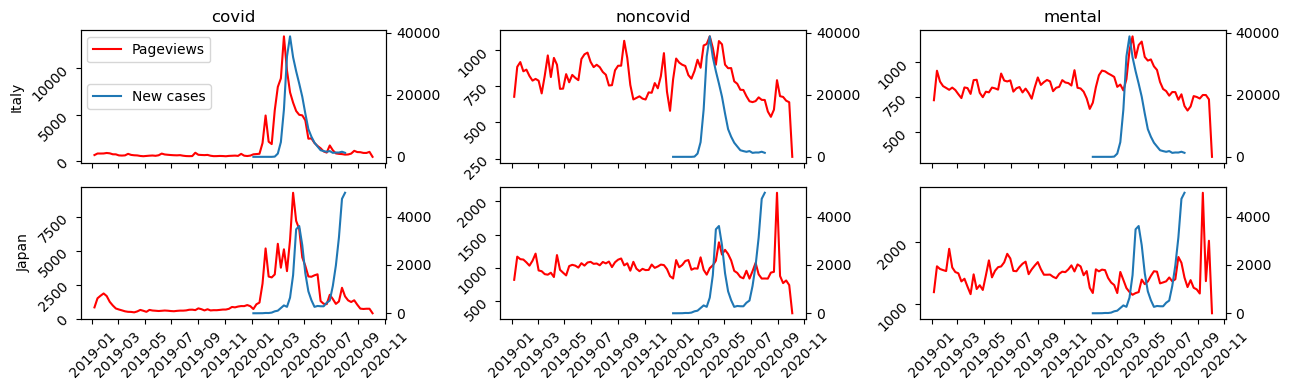

In [3]:
# Data visualization: mean pageviews per week based on category
fig, ax = plt.subplots(2, 3, figsize=(13, 4), sharex=True)
for i, country in enumerate(['it', 'ja']):
    for j, name in enumerate(['covid', 'noncovid', 'mental']):
        row = i
        col = j
        ax[row, col].plot(pageview[country]['pageviews'][name].resample('W').sum().mean(axis=1), 'r', label = 'Pageviews')
        ax[0, 0].legend()
        ax0 = ax[row, col].twinx()
        ax0.plot(covid[country]['New_cases'].resample('W').sum(), label = 'New cases')
        ax[0, col].set_title(name)
        ax[row, col].tick_params(labelrotation=45)
        if (i == 0) & (j == 0):
            ax0.legend(loc = 6)
ax[0, 0].set_ylabel('Italy')
ax[1, 0].set_ylabel('Japan')
plt.tight_layout() 
plt.show()

1. Find best shift

In [4]:
def find_best_shift(pageviews, covid, bound):
    '''
    Move the covid data along x-axis(time), find the best shift(highest correlation coefficient)
    '''
    res = []
    for delta_t in range(bound):
            idx = covid.index-pd.DateOffset(delta_t)  # time interval
            temp1 = pageviews[pageviews.index.isin(idx)].mean(axis=1)
            temp2 = covid['New_cases']
            res.append(stats.spearmanr(temp1, temp2, nan_policy='omit')[0])
    return np.argmin(np.array(res))

In [7]:
for country in ['fi', 'ja', 'no', 'sv', 'da', 'sr', 'nl', 'ko', 'de', 'en', 'fr', 'it']: 
    print('-----for country {}-----'.format(country))
    s = find_best_shift(pageview[country]['pageviews']['covid'], covid[country], 30)
    print(s)

-----for country fi-----
0
-----for country ja-----
0
-----for country no-----
0
-----for country sv-----
0
-----for country da-----
0
-----for country sr-----
0
-----for country nl-----
0
-----for country ko-----
14
-----for country de-----
0
-----for country en-----
0
-----for country fr-----
0
-----for country it-----
0


Overall, no covid data need shift. The other two categories were not tested because the correlations are low.

2. Correlation analysis (covid, non-covid, mental)

[Text(0.5, 1.0, 'Italy')]

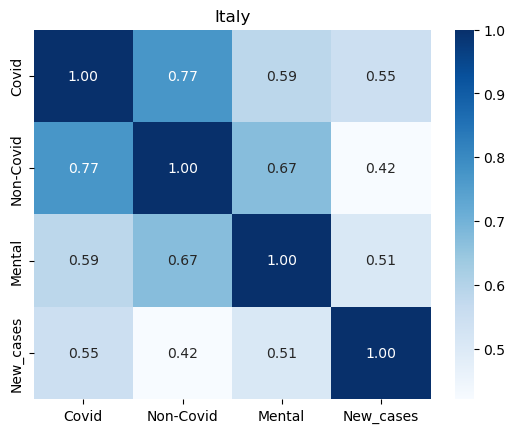

In [8]:
# Italy
page_it = pd.DataFrame()
page_it['Covid'] = pageview['it']['pageviews']['covid'].mean(axis=1)
page_it['Non-Covid'] = pageview['it']['pageviews']['noncovid'].mean(axis=1)
page_it['Mental'] = pageview['it']['pageviews']['mental'].mean(axis=1)
it_covid_page = pd.concat([page_it, covid['it']['New_cases']], axis=1, join="inner").resample('W').sum()

rho, p = stats.spearmanr(it_covid_page, nan_policy='omit')

sns.heatmap(rho, cmap="Blues", fmt=".2f", annot=True, xticklabels=it_covid_page.columns, yticklabels=it_covid_page.columns).set(title='Italy')

[Text(0.5, 1.0, 'Norway')]

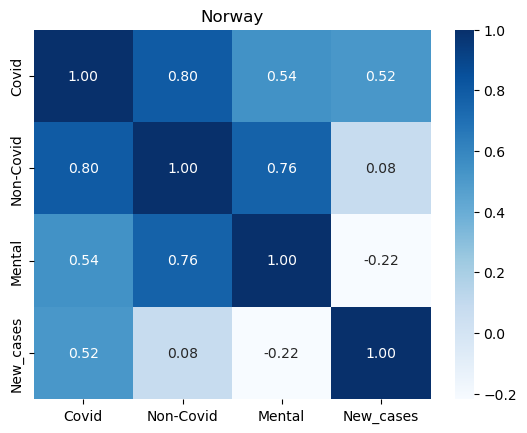

In [9]:
# Norway
page_no = pd.DataFrame()
page_no['Covid'] = pageview['no']['pageviews']['covid'].mean(axis=1)
page_no['Non-Covid'] = pageview['no']['pageviews']['noncovid'].mean(axis=1)
page_no['Mental'] = pageview['no']['pageviews']['mental'].mean(axis=1)
no_covid_page = pd.concat([page_no, covid['no']['New_cases']], axis=1, join="inner").resample('W').sum()

rho, p = stats.spearmanr(no_covid_page, nan_policy='omit')

sns.heatmap(rho, cmap="Blues", fmt=".2f", annot=True, xticklabels=no_covid_page.columns, yticklabels=no_covid_page.columns).set(title='Norway')

3. Correlation analysis (categories)

In [10]:
# Get the set of categories under 'Covid'
covid_class = np.unique(pageview['it']['category']['covid']['category'].dropna())
covid_class

array(['flu', 'gastrointestinal', 'pandemic', 'respiratory'], dtype=object)

In [11]:
# Get the set of categories under 'Mental'
mental_class = np.unique(pageview['it']['category']['mental']['category'].dropna())
mental_class

array(['death', 'disorder', 'mild', 'violence'], dtype=object)

Non-covid was not analyzed due to low correlation.

In [12]:
def find_page(country, collect, category):
    '''
    Find all the pages under each category.
    collect: covid, mental
    category: the specific category under covid or mental
    '''
    for name, group in pageview[country]['category'][collect].groupby('category'):
        if name == category:
            df_covid = pageview[country]['pageviews'][collect].transpose()
            return df_covid[df_covid.index.isin(group['index'])].transpose().resample('W').sum()

In [13]:
def compute_corr(country, collect, category):
    '''
    Compute the correlation between pageview based on category and new cases.
    collect: covid, mental
    category: the specific category under covid or mental
    '''
    pageview_df = find_page(country, collect, category)
    df = pd.concat([pageview_df, covid[country]['New_cases'].resample('W').sum()], axis=1, join="inner")
    df_out=[]
    for i in range(df.shape[1]-1):
        rho, p = stats.spearmanr(df.iloc[:, -1], df.iloc[:, i], nan_policy='omit')
        df_out.append(rho)
    return pd.DataFrame(df_out, index = df.columns[:-1], columns = ['corr']).sort_values('corr')

In [15]:
# Calculate the correlation across countries, store the results in mental_df and covid_df
country_list = ['fi', 'ja', 'no', 'sv', 'da', 'sr', 'nl', 'ko', 'de', 'en', 'fr', 'it']
mental_df = pd.DataFrame(columns=country_list, index=mental_class)
for country in country_list:
    for c in mental_class:
        mental_df[country][c] = compute_corr(country, 'mental', c)['corr'].mean()
        
covid_df = pd.DataFrame(columns=country_list, index=covid_class)
for country in country_list:
    for c in covid_class:
        covid_df[country][c] = compute_corr(country, 'covid', c)['corr'].mean()

c:\Users\43hel\anaconda3\envs\ADA\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\43hel\anaconda3\envs\ADA\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
c:\Users\43hel\anaconda3\envs\ADA\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [16]:
# Covid
categories = covid_class

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=covid_df['no'],
      theta=categories,
      fill='toself',
      name='Norway'
))
fig.add_trace(go.Scatterpolar(
      r=covid_df['it'],
      theta=categories,
      fill='toself',
      name='Italy'
))
fig.add_trace(go.Scatterpolar(
      r=covid_df['ko'],
      theta=categories,
      fill='toself',
      name='Korea'
))
fig.add_trace(go.Scatterpolar(
      r=covid_df['da'],
      theta=categories,
      fill='toself',
      name='Denmark'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-0.5, 0.8]
    )),
  showlegend=True
)

fig.show()

# Save the file
# fig.write_html("rader_covid.html")

In [17]:
# Mental
categories = mental_class

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=mental_df['fi'],
      theta=categories,
      fill='toself',
      name='Norway'
))
fig.add_trace(go.Scatterpolar(
      r=mental_df['it'],
      theta=categories,
      fill='toself',
      name='Italy'
))
fig.add_trace(go.Scatterpolar(
      r=mental_df['ko'],
      theta=categories,
      fill='toself',
      name='Korea'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-0.3, 0.4]
    )),
  showlegend=True
)

fig.show()

# Save file
# fig.write_html("rader_mental.html")

4. Correlation analysis (based on specif topic)

In [20]:
# Get the correlation coefficient for each topic
cor_covid = pd.DataFrame()
cor_mental = pd.DataFrame()
# # Data
for collect in ['covid', 'mental']:
    if collect == 'covid':
        class_plot = covid_class
    else:
        class_plot = mental_class
    for cat in class_plot:
        cor = compute_corr('it', collect, cat)
        cor['category'] = cat
        if collect == 'covid':
            cor_covid = pd.concat([cor_covid, cor]).sort_values(by='corr',ascending=False)
        else:
            cor_mental = pd.concat([cor_mental, cor]).sort_values(by='corr',ascending=False)

c:\Users\43hel\anaconda3\envs\ADA\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



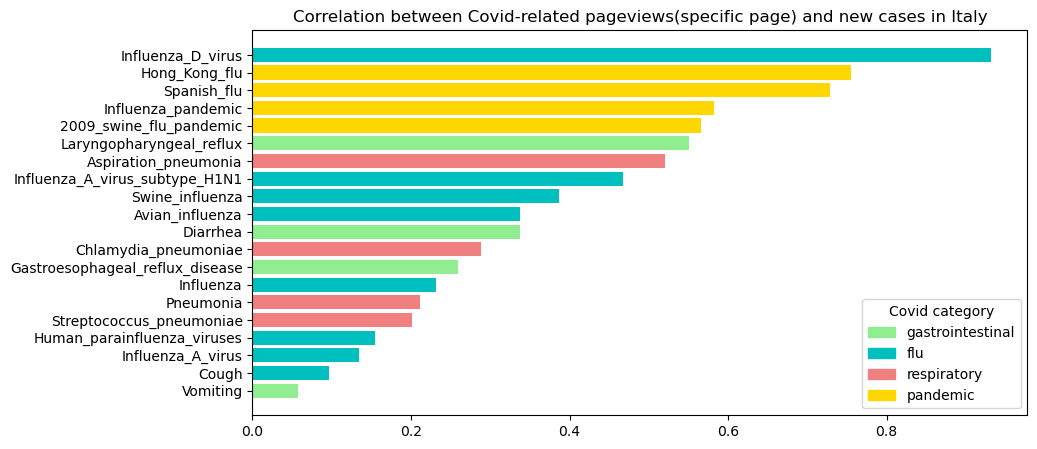

In [21]:
# Show the top 20 pages about Covid in Italy
plt.figure(figsize=(10,5))
df = cor_covid[:20].sort_values(by='corr')
colors = {'respiratory': 'lightcoral', 'gastrointestinal': 'lightgreen', 'pandemic': 'gold', 'flu':'c'}
plt.barh(df.index, df['corr'], color = [colors[i] for i in df['category']])
labels = df['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Covid category")
plt.title('Correlation between Covid-related pageviews(specific page) and new cases in Italy')
plt.show()

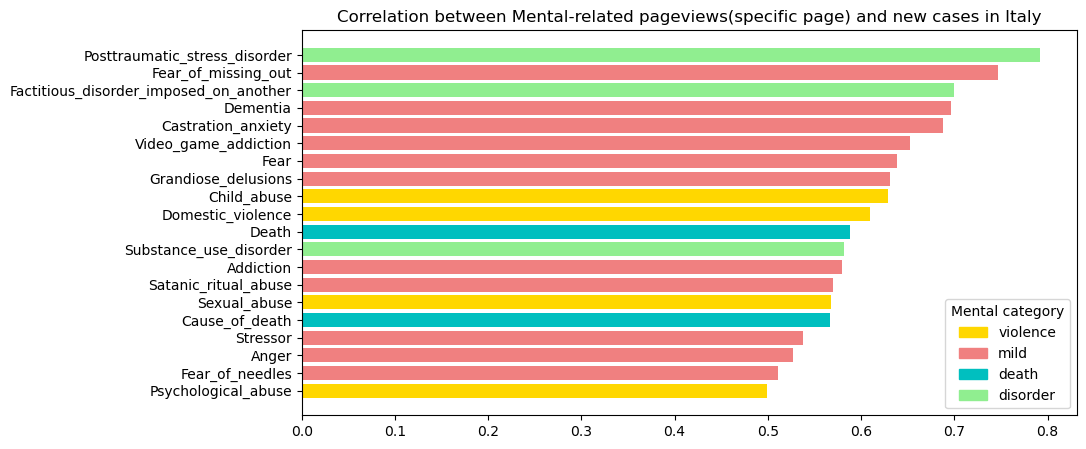

In [22]:
# Show the top 20 pages about mental in Italy
plt.figure(figsize=(10,5))
df = cor_mental[:20].sort_values(by='corr')
colors = {'death': 'c', 'disorder': 'lightgreen', 'mild': 'lightcoral', 'violence':'gold'}
plt.barh(df.index, df['corr'], color = [colors[i] for i in df['category']])
labels = df['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Mental category")
plt.title('Correlation between Mental-related pageviews(specific page) and new cases in Italy')
plt.show()